# Video Watch Percentage

This notebook loads csv file that contains user activities on a specified course, then calculates the time spent by each user on each video.

## 1. Define function to calculate duration

In [290]:
#multiple start time - last function that works
import pandas as pd
from datetime import datetime
import re

def construct_usr_component_record(input_usr_dict):
    # Define pattern to find component id and type
    pattern = r'(?:/courses/[^/]+/(discussion)/[^/]+/([\da-f]+)/)|(?:@(\w+)\+block@([\da-f]+)/)'

    # Define initial state
    prev_seq_id = "nan"
    prev_comp_id = "nan"
    cur_comp_type = "nan"
    tmp_usr_component_sequence = dict()
    cur_s_time = "nan"
    
    # Loop through each activity
    for row_idx, (tmp_type, tmp_source, tmp_time) in enumerate(zip(input_usr_dict.event_type, input_usr_dict.event_source, input_usr_dict.time)):
        
        # Filter only non-server sources
        if tmp_source != "server":
            continue

        # Find all matches in the string
        matches = re.findall(pattern, tmp_type)
        
        # Check if there are any matches (only sequences and components)
        if matches:
            for match in matches:
                if match[0] and match[1]:  # Matched discussion                    
                    X, Y = match[0], match[1]
                elif match[2] and match[3]:  # Matched component and sequential
                    X, Y = match[2], match[3]

                if X == "sequential":  # Sequential 
                    if prev_seq_id != Y:
                        prev_seq_id = Y
                else:  # html, problem, video components
                    if prev_comp_id != Y:
                        # Record the start time for a new component
                        cur_comp_type = X
                        cur_s_time = tmp_time

                        if prev_comp_id != "nan": 
                            prev_e_time = tmp_time
                            
                            # Convert string times to datetime objects
                            prev_s_time_dt = datetime.strptime(prev_s_time, "%Y-%m-%dT%H:%M:%S.%f%z")
                            prev_e_time_dt = datetime.strptime(prev_e_time, "%Y-%m-%dT%H:%M:%S.%f%z")
                            
                            # Calculate the duration in minutes
                            duration = (prev_e_time_dt - prev_s_time_dt).total_seconds() / 60.0

                            if duration > 60:
                                continue

                            # Append the new times and duration
                            if prev_comp_id in tmp_usr_component_sequence:
                                tmp_usr_component_sequence[prev_comp_id]["s_time"].append(prev_s_time)
                                tmp_usr_component_sequence[prev_comp_id]["e_time"].append(prev_e_time)
                                tmp_usr_component_sequence[prev_comp_id]["duration"].append(duration)
                            else:
                                tmp_usr_component_sequence[prev_comp_id] = {
                                    "type": prev_comp_type,
                                    "id": prev_comp_id,
                                    "s_time": [prev_s_time],
                                    "e_time": [prev_e_time],
                                    "duration": [duration]
                                }

                        # Update to the current component and start time
                        prev_comp_id = Y
                        prev_s_time = cur_s_time
                        prev_comp_type = cur_comp_type

    # Convert to DataFrame
    return pd.DataFrame(tmp_usr_component_sequence)

## 2. Initialize paths and file names

In [291]:
COURSE_NAME = 'EE101J'
COURSE_YEAR = '2021'
EVENT_LOG_FILE_PATH = 'course_data/'+ COURSE_NAME + '/categorized/categorized_student_event_' + COURSE_YEAR+ '_csv_data.csv'
ENROLLMENT_MODE = 'verified'
OUTLIERS_FILE_PATH = 'course_data/'+ COURSE_NAME + '/outliers.json'
VIDEO_DURATION_FILE_PATH = 'course_data/'+ COURSE_NAME + '/'+COURSE_NAME + '_video_duration.xlsx'
WATCH_PERCENTAGE_FILE_PATH = 'course_data/'+ COURSE_NAME + '/' + '/watch_percentage/'+ ENROLLMENT_MODE+'/' +COURSE_NAME + '_' + ENROLLMENT_MODE + '_' + COURSE_YEAR + '_watch_percentage.csv'
NONLECTURE_FILE_PATH = 'course_data/'+ COURSE_NAME + '/non_lecture.json'


## 3. Load data

In [292]:
df = pd.read_csv(EVENT_LOG_FILE_PATH)

# Filter only `audit` users
df_filtered = df[df["enrollment_mode"] == ENROLLMENT_MODE]

# Keep only relevant columns
df_filtered = df_filtered[["username", "event_type", "event_source", "time"]]


## 4. Exclude outlier users

In [293]:
import json

with open(OUTLIERS_FILE_PATH, 'r') as f:
    outliers = json.load(f)

df_filtered_wo_outliers = df_filtered[~df_filtered['username'].isin(outliers)]
df_filtered_wo_outliers

,username,event_type,event_source,time
15854,0ff3bf487129f81dde182c5156efdf8146f4831a,edx.course.enrollment.activated,server,2021-05-14T07:30:51.764393+00:00
15855,0ff3bf487129f81dde182c5156efdf8146f4831a,/courses/course-v1:TokyoTechX+EE101Jx+1T2021/c...,server,2021-05-19T09:08:05.982399+00:00
15856,0ff3bf487129f81dde182c5156efdf8146f4831a,/courses/course-v1:TokyoTechX+EE101Jx+1T2021/j...,server,2021-05-19T09:09:11.968890+00:00
15857,0ff3bf487129f81dde182c5156efdf8146f4831a,/courses/course-v1:TokyoTechX+EE101Jx+1T2021/x...,server,2021-05-19T09:09:14.860913+00:00
15858,0ff3bf487129f81dde182c5156efdf8146f4831a,/courses/course-v1:TokyoTechX+EE101Jx+1T2021/x...,server,2021-05-19T09:09:14.884782+00:00
...,...,...,...,...
274732,fd1adf461f61a9d4168e705c4059b82b6f3bbda8,/courses/course-v1:TokyoTechX+EE101Jx+1T2021/x...,server,2021-11-01T21:58:03.497266+00:00
274733,fd1adf461f61a9d4168e705c4059b82b6f3bbda8,/courses/course-v1:TokyoTechX+EE101Jx+1T2021/j...,server,2021-11-01T21:58:07.878460+00:00
274734,fd1adf461f61a9d4168e705c4059b82b6f3bbda8,/api/courseware/course/course-v1:TokyoTechX+EE...,server,2021-11-01T21:58:11.061278+00:00
274735,fd1adf461f61a9d4168e705c4059b82b6f3bbda8,/courses/course-v1:TokyoTechX+EE101Jx+1T2021/x...,server,2021-11-01T21:58:17.157522+00:00


## 5. Calculate duration of engagement on each content

In [294]:
# Function to apply processing per user
def process_user_logs(user_df):
    return construct_usr_component_record(user_df)

# Group by username and process each user's data
results = df_filtered_wo_outliers.groupby("username").apply(process_user_logs)

# Display the results
results.head(5)

/var/folders/hq/mr_d9f8x11dfzc_f03z9xzbw0000gn/T/ipykernel_55279/3451499937.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df_filtered_wo_outliers.groupby("username").apply(process_user_logs)


5dbb432a16834eb1a56cb03ec3e448ab  \
username                                                                                               
0ff3bf487129f81dde182c5156efdf8146f4831a type                                                  video   
                                         id                         5dbb432a16834eb1a56cb03ec3e448ab   
                                         s_time    [2021-05-19T09:09:14.860913+00:00, 2021-05-19T...   
                                         e_time    [2021-05-19T09:09:14.884782+00:00, 2021-05-19T...   
                                         duration                 [0.0003978166666666667, 2.8298925]   

                                                                    65cccf6a4c174d2aac0a478ee1cd36e2  \
username                                                                                               
0ff3bf487129f81dde182c5156efdf8146f4831a type                                                  video   
                                         id                         65cccf6a4c174d2aac0a478ee1cd36e2   
                                         s_time    [2021-05-19T09:09:14.884782+00:00, 2021-05-19T...   
                                         e_time    [2021-05-19T09:24:30.566966+00:00, 2021-05-19T...   
                                         duration           [15.261369733333334, 0.4554857666666667]   

                                                     79a839bbf86d4c449e7e61838b8dc278  \
username                                                                                
0ff3bf487129f81dde182c5156efdf8146f4831a type                                    html   
                                         id          79a839bbf86d4c449e7e61838b8dc278   
                                         s_time    [2021-05-19T09:27:47.689662+00:00]   
                                         e_time    [2021-05-19T09:28:14.786920+00:00]   
                                         duration                [0.4516209666666667]   

                                                     7475ba9dae284d6c93e6d97b25be228a  \
username                                                                                
0ff3bf487129f81dde182c5156efdf8146f4831a type                                    html   
                                         id          7475ba9dae284d6c93e6d97b25be228a   
                                         s_time    [2021-05-19T09:28:14.786920+00:00]   
                                         e_time    [2021-05-19T09:28:22.117069+00:00]   
                                         duration               [0.12216914999999999]   

                                                     5525ce814b704feaa8067afb8c011656  \
username                                                                                
0ff3bf487129f81dde182c5156efdf8146f4831a type                                    html   
                                         id          5525ce814b704feaa8067afb8c011656   
                                         s_time    [2021-05-19T09:28:22.117069+00:00]   
                                         e_time    [2021-05-19T09:28:49.931410+00:00]   
                                         duration               [0.46357234999999997]   

                                                   ebf9b8e57685d7ea5090a7e18ec37e0fbcc40ac0  \
username                                                                                      
0ff3bf487129f81dde182c5156efdf8146f4831a type                                    discussion   
                                         id        ebf9b8e57685d7ea5090a7e18ec37e0fbcc40ac0   
                                         s_time          [2021-05-19T09:28:49.931410+00:00]   
                                         e_time          [2021-05-19T09:28:50.990929+00:00]   
                                         duration                              [0.01765865]   

                                                     09e254da3e2e4adebda

In [295]:
# Resetting the index to get 'username' as a column, if it's currently set as an index
result_reset = results.reset_index()

# Melt the dataframe to restructure it
result_melted = result_reset.melt(id_vars=['username', 'level_1'], 
                                  value_vars=result_reset.columns[2:],  # all ID columns
                                  var_name='id', value_name='value')
result_pivoted = result_melted.pivot_table(index=['username', 'id'], columns='level_1', values='value', aggfunc='first')
# Rename existing 'id' column to avoid conflict
result_pivoted = result_pivoted.rename(columns={'id': 'id_old'})

# Reset index, which adds the index 'id' column back
result_pivoted = result_pivoted.reset_index()

In [296]:
result_pivoted.drop(columns=['id_old'], inplace=True)
result_pivoted

level_1,username,id,duration,e_time,s_time,type
0,0ff3bf487129f81dde182c5156efdf8146f4831a,05a8f4d1e38243cdb052eee954b7a403,"[0.00014533333333333333, 0.00087675, 0.1094771...","[2021-05-19T09:35:14.834024+00:00, 2021-05-19T...","[2021-05-19T09:35:14.825304+00:00, 2021-05-19T...",video
1,0ff3bf487129f81dde182c5156efdf8146f4831a,09e254da3e2e4adebda7c4bb3974789f,[0.0646801],[2021-05-19T09:28:54.871735+00:00],[2021-05-19T09:28:50.990929+00:00],html
2,0ff3bf487129f81dde182c5156efdf8146f4831a,0bbd93b608b447818a544a20416e2572,"[0.00018148333333333332, 0.006230083333333333,...","[2021-05-19T09:31:14.228499+00:00, 2021-05-19T...","[2021-05-19T09:31:14.217610+00:00, 2021-05-19T...",video
3,0ff3bf487129f81dde182c5156efdf8146f4831a,166bf6026682498e81ee90f2eb36453d,[0.10240788333333332],[2021-05-19T09:29:02.042510+00:00],[2021-05-19T09:28:55.898037+00:00],html
4,0ff3bf487129f81dde182c5156efdf8146f4831a,29baf386a89e43a583d54e96ec69eb50,[1.2227092166666667],[2021-05-19T10:01:22.568298+00:00],[2021-05-19T10:00:09.205745+00:00],html
...,...,...,...,...,...,...
326,fd1adf461f61a9d4168e705c4059b82b6f3bbda8,8ebb7da1745b4c9296b552d8b8f53068,[0.00037614999999999995],[2021-10-20T22:03:25.988257+00:00],[2021-10-20T22:03:25.965688+00:00],html
327,fd1adf461f61a9d4168e705c4059b82b6f3bbda8,b18ee5f0ca5647548749a1948c24ce15,"[8.073333333333334e-05, 2.5542700833333334]","[2021-10-20T21:59:37.846457+00:00, 2021-10-20T...","[2021-10-20T21:59:37.841613+00:00, 2021-10-20T...",video
328,fd1adf461f61a9d4168e705c4059b82b6f3bbda8,ed4d9980745c4a6cbc6363c149c95370,[0.008447066666666668],[2021-10-20T21:59:39.656831+00:00],[2021-10-20T21:59:39.150007+00:00],html
329,fd1adf461f61a9d4168e705c4059b82b6f3bbda8,f11d8effcec349f9b44bb4d8671ded5f,[0.9012592833333334],[2021-10-20T22:00:33.732388+00:00],[2021-10-20T21:59:39.656831+00:00],html


## 6. Filter only video content

In [297]:
result_pivoted = result_pivoted[result_pivoted['type'] == 'video']

result_pivoted.head(10)

level_1,username,id,duration,e_time,s_time,type
0,0ff3bf487129f81dde182c5156efdf8146f4831a,05a8f4d1e38243cdb052eee954b7a403,"[0.00014533333333333333, 0.00087675, 0.1094771...","[2021-05-19T09:35:14.834024+00:00, 2021-05-19T...","[2021-05-19T09:35:14.825304+00:00, 2021-05-19T...",video
2,0ff3bf487129f81dde182c5156efdf8146f4831a,0bbd93b608b447818a544a20416e2572,"[0.00018148333333333332, 0.006230083333333333,...","[2021-05-19T09:31:14.228499+00:00, 2021-05-19T...","[2021-05-19T09:31:14.217610+00:00, 2021-05-19T...",video
12,0ff3bf487129f81dde182c5156efdf8146f4831a,5dbb432a16834eb1a56cb03ec3e448ab,"[0.0003978166666666667, 2.8298925]","[2021-05-19T09:09:14.884782+00:00, 2021-05-19T...","[2021-05-19T09:09:14.860913+00:00, 2021-05-19T...",video
13,0ff3bf487129f81dde182c5156efdf8146f4831a,6251fb4af24e4a108c53a0b74dc3a530,"[0.010486433333333333, 4.693174583333334, 1.80...","[2021-05-19T10:00:09.179929+00:00, 2021-05-19T...","[2021-05-19T10:00:08.550743+00:00, 2021-05-19T...",video
14,0ff3bf487129f81dde182c5156efdf8146f4831a,65cccf6a4c174d2aac0a478ee1cd36e2,"[15.261369733333334, 0.4554857666666667]","[2021-05-19T09:24:30.566966+00:00, 2021-05-19T...","[2021-05-19T09:09:14.884782+00:00, 2021-05-19T...",video
15,0ff3bf487129f81dde182c5156efdf8146f4831a,6e68f1662458465c9376bf49a0bdaddf,"[0.0006610833333333333, 0.0002619666666666667,...","[2021-05-19T10:22:10.353048+00:00, 2021-05-19T...","[2021-05-19T10:22:10.313383+00:00, 2021-05-19T...",video
19,0ff3bf487129f81dde182c5156efdf8146f4831a,7cfd0818012547ae8ebe167ad7392145,"[0.017104183333333335, 11.900750583333332, 2.0...","[2021-05-19T09:35:15.860275+00:00, 2021-05-19T...","[2021-05-19T09:35:14.834024+00:00, 2021-05-19T...",video
20,0ff3bf487129f81dde182c5156efdf8146f4831a,8a0f0c741812451a86fdbc1322181a34,"[0.00664255, 9.884748683333333, 0.556179616666...","[2021-05-19T10:00:08.550743+00:00, 2021-05-19T...","[2021-05-19T10:00:08.152190+00:00, 2021-05-19T...",video
27,0ff3bf487129f81dde182c5156efdf8146f4831a,c3d49669f323435b8a2b54e0e9008375,"[0.00039569999999999997, 3.7261211166666666, 0...","[2021-05-19T09:31:14.252241+00:00, 2021-05-19T...","[2021-05-19T09:31:14.228499+00:00, 2021-05-19T...",video
32,0ff3bf487129f81dde182c5156efdf8146f4831a,e4df0eb952e74477b7e5ff5898ad1b6f,"[0.017507116666666666, 0.35496053333333333, 0....","[2021-05-19T10:22:11.403475+00:00, 2021-05-19T...","[2021-05-19T10:22:10.353048+00:00, 2021-05-19T...",video


## Exclude non lecture video

In [298]:
with open(NONLECTURE_FILE_PATH, 'r') as f:
    non_lecture = json.load(f)
result_pivoted = result_pivoted[~result_pivoted['id'].isin(non_lecture)]

## 7. Obtain total video watch duration

In [299]:
result_pivoted['total_watch_duration'] = result_pivoted['duration'].apply(sum)

In [300]:
result_pivoted.head(10)

level_1,username,id,duration,e_time,s_time,type,total_watch_duration
0,0ff3bf487129f81dde182c5156efdf8146f4831a,05a8f4d1e38243cdb052eee954b7a403,"[0.00014533333333333333, 0.00087675, 0.1094771...","[2021-05-19T09:35:14.834024+00:00, 2021-05-19T...","[2021-05-19T09:35:14.825304+00:00, 2021-05-19T...",video,1.756702
2,0ff3bf487129f81dde182c5156efdf8146f4831a,0bbd93b608b447818a544a20416e2572,"[0.00018148333333333332, 0.006230083333333333,...","[2021-05-19T09:31:14.228499+00:00, 2021-05-19T...","[2021-05-19T09:31:14.217610+00:00, 2021-05-19T...",video,0.006616
12,0ff3bf487129f81dde182c5156efdf8146f4831a,5dbb432a16834eb1a56cb03ec3e448ab,"[0.0003978166666666667, 2.8298925]","[2021-05-19T09:09:14.884782+00:00, 2021-05-19T...","[2021-05-19T09:09:14.860913+00:00, 2021-05-19T...",video,2.830290
13,0ff3bf487129f81dde182c5156efdf8146f4831a,6251fb4af24e4a108c53a0b74dc3a530,"[0.010486433333333333, 4.693174583333334, 1.80...","[2021-05-19T10:00:09.179929+00:00, 2021-05-19T...","[2021-05-19T10:00:08.550743+00:00, 2021-05-19T...",video,6.509080
14,0ff3bf487129f81dde182c5156efdf8146f4831a,65cccf6a4c174d2aac0a478ee1cd36e2,"[15.261369733333334, 0.4554857666666667]","[2021-05-19T09:24:30.566966+00:00, 2021-05-19T...","[2021-05-19T09:09:14.884782+00:00, 2021-05-19T...",video,15.716856
15,0ff3bf487129f81dde182c5156efdf8146f4831a,6e68f1662458465c9376bf49a0bdaddf,"[0.0006610833333333333, 0.0002619666666666667,...","[2021-05-19T10:22:10.353048+00:00, 2021-05-19T...","[2021-05-19T10:22:10.313383+00:00, 2021-05-19T...",video,2.398820
19,0ff3bf487129f81dde182c5156efdf8146f4831a,7cfd0818012547ae8ebe167ad7392145,"[0.017104183333333335, 11.900750583333332, 2.0...","[2021-05-19T09:35:15.860275+00:00, 2021-05-19T...","[2021-05-19T09:35:14.834024+00:00, 2021-05-19T...",video,16.116586
20,0ff3bf487129f81dde182c5156efdf8146f4831a,8a0f0c741812451a86fdbc1322181a34,"[0.00664255, 9.884748683333333, 0.556179616666...","[2021-05-19T10:00:08.550743+00:00, 2021-05-19T...","[2021-05-19T10:00:08.152190+00:00, 2021-05-19T...",video,11.773293
27,0ff3bf487129f81dde182c5156efdf8146f4831a,c3d49669f323435b8a2b54e0e9008375,"[0.00039569999999999997, 3.7261211166666666, 0...","[2021-05-19T09:31:14.252241+00:00, 2021-05-19T...","[2021-05-19T09:31:14.228499+00:00, 2021-05-19T...",video,5.242563
32,0ff3bf487129f81dde182c5156efdf8146f4831a,e4df0eb952e74477b7e5ff5898ad1b6f,"[0.017507116666666666, 0.35496053333333333, 0....","[2021-05-19T10:22:11.403475+00:00, 2021-05-19T...","[2021-05-19T10:22:10.353048+00:00, 2021-05-19T...",video,0.372581


## 7. Obtain Video watch percentage

In [301]:
import os
# Read video duration file
if os.path.exists(VIDEO_DURATION_FILE_PATH):
    print(f"File found: {VIDEO_DURATION_FILE_PATH}")
else:
    print(f"File not found at: {VIDEO_DURATION_FILE_PATH}")
duration_df = pd.read_excel(VIDEO_DURATION_FILE_PATH)
duration_df = duration_df.rename(columns={'duration': 'video_duration'})
print(duration_df)

File not found at: course_data/EE101J/EE101J_video_duration.xlsx


FileNotFoundError: [Errno 2] No such file or directory: 'course_data/EE101J/EE101J_video_duration.xlsx'

In [ ]:
merged_watch_df = pd.merge(result_pivoted, duration_df, left_on='id', right_on='url_name', how='left')
merged_watch_df['watch_percentage'] = merged_watch_df['total_watch_duration'] / merged_watch_df['video_duration'] 

merged_watch_df.head(10)

,username,id,duration,e_time,s_time,type,total_watch_duration,url_name,video_duration,watch_percentage
0,00f8d61119ddee80377fd10307079c50b5506ff6,c3403b4bddfb40759d6dc0d630a75484,[1.8635341166666668],[2023-04-15T20:36:26.634175+00:00],[2023-04-15T20:34:34.822128+00:00],video,1.863534,c3403b4bddfb40759d6dc0d630a75484,0.54363,3.427946
1,00f8d61119ddee80377fd10307079c50b5506ff6,eca85b3f2d39415d86cc7aa1130cf96b,[26.878863766666665],[2023-04-15T21:03:19.366001+00:00],[2023-04-15T20:36:26.634175+00:00],video,26.878864,eca85b3f2d39415d86cc7aa1130cf96b,3.53777,7.597685
2,0989ceb070054f7436a65043306470e6bd8b35bd,a07a607263e541418ace2101e5a9f1fd,"[0.2513445166666667, 5.601988833333333]","[2023-06-25T15:41:23.897733+00:00, 2023-06-25T...","[2023-06-25T15:41:08.817062+00:00, 2023-06-25T...",video,5.853333,a07a607263e541418ace2101e5a9f1fd,5.09120,1.149696
3,0989ceb070054f7436a65043306470e6bd8b35bd,a511e497e3a14e50b7e44aca1f726ebe,"[3.9665570333333333, 0.42073475]","[2023-06-25T15:30:48.733020+00:00, 2023-06-25T...","[2023-06-25T15:26:50.739598+00:00, 2023-06-25T...",video,4.387292,a511e497e3a14e50b7e44aca1f726ebe,2.97243,1.475995
4,0989ceb070054f7436a65043306470e6bd8b35bd,aa0865457c81482e95ef0c66dbc935ab,[3.7184873499999997],[2023-06-25T15:40:09.644287+00:00],[2023-06-25T15:36:26.535046+00:00],video,3.718487,aa0865457c81482e95ef0c66dbc935ab,3.41688,1.088270
5,0989ceb070054f7436a65043306470e6bd8b35bd,c3403b4bddfb40759d6dc0d630a75484,[1.05993605],[2023-06-25T15:21:29.718406+00:00],[2023-06-25T15:20:26.122243+00:00],video,1.059936,c3403b4bddfb40759d6dc0d630a75484,0.54363,1.949738
6,0989ceb070054f7436a65043306470e6bd8b35bd,eca85b3f2d39415d86cc7aa1130cf96b,[5.237153183333334],[2023-06-25T15:26:43.947597+00:00],[2023-06-25T15:21:29.718406+00:00],video,5.237153,eca85b3f2d39415d86cc7aa1130cf96b,3.53777,1.480354
7,0989ceb070054f7436a65043306470e6bd8b35bd,f417d80bbe1447ecada2ad5abd965236,[3.681699],[2023-06-25T15:36:20.473202+00:00],[2023-06-25T15:32:39.571262+00:00],video,3.681699,f417d80bbe1447ecada2ad5abd965236,3.10648,1.185167
8,09f545abfd5c6e37923228d778df6d77e8a94de6,a07a607263e541418ace2101e5a9f1fd,[16.68982851666667],[2023-10-02T04:37:25.677167+00:00],[2023-10-02T04:20:44.287456+00:00],video,16.689829,a07a607263e541418ace2101e5a9f1fd,5.09120,3.278172
9,09f545abfd5c6e37923228d778df6d77e8a94de6,a511e497e3a14e50b7e44aca1f726ebe,"[35.071279483333335, 0.18990943333333332, 2.03...","[2023-10-02T03:37:36.582576+00:00, 2023-10-02T...","[2023-10-02T03:02:32.305807+00:00, 2023-10-02T...",video,37.492277,a511e497e3a14e50b7e44aca1f726ebe,2.97243,12.613342


## 8. Calculate average video watch percentage for each user

In [ ]:
# Compute the average watch percentage per user
avg_watch_df = merged_watch_df.groupby("username", as_index=False)["watch_percentage"].mean()

avg_watch_df.head(10)

,username,watch_percentage
0,00f8d61119ddee80377fd10307079c50b5506ff6,5.512816
1,0989ceb070054f7436a65043306470e6bd8b35bd,1.388203
2,09f545abfd5c6e37923228d778df6d77e8a94de6,7.040773
3,0b5dd94c7a135842a1bcbdce2d0c6eec8558c43d,4.444677
4,149748a5e3b676141d6ecfa14f935c9462ea27ff,1.420662
5,1d0651199a3e6da0944c0a816c75bff92615ece2,1.615905
6,1e90ecf89a0acb787ec747eb9633d3812165ea21,6.710388
7,20467d45cb7463024af0786e0f32550e1a6e4260,6.448506
8,2b47e34cae1cbcf5d9109d0586a1b7b0db42e40c,121.602532
9,2e7a2107ff495513be4738370045044ca09fa787,0.685544


## 9. Exclude outlier watch percentage

In [ ]:
import pandas as pd

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = avg_watch_df['watch_percentage'].quantile(0.25)
Q3 = avg_watch_df['watch_percentage'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define bounds for filtering outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to keep only rows within the IQR bounds
filtered_df = avg_watch_df[(avg_watch_df['watch_percentage'] >= lower_bound) & 
                           (avg_watch_df['watch_percentage'] <= upper_bound)]


In [ ]:
filtered_df.to_csv(WATCH_PERCENTAGE_FILE_PATH, index=False)

## 9. Visualize distribution

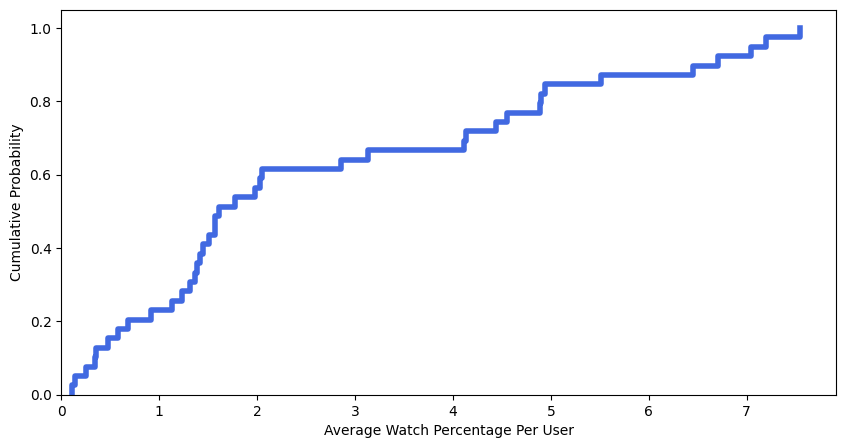

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the custom bin edges (0 to 5 with intervals of 0.25)
#bins = np.arange(0, 5.25, 0.25)

# Create a figure and plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.ecdfplot(data=filtered_df, x="watch_percentage", ax=ax, color="royalblue", linewidth=4)

# Add labels
ax.set_xlabel("Average Watch Percentage Per User")
ax.set_ylabel("Cumulative Probability")
#ax.set_title(GRAPH_TITLE)

# Adjust axes
ax.set_xlim(left=0)
ax.set_ylim(bottom=0, top=1.05)  # Since CDF values go from 0 to 1

# Adjust spines to intersect at (0, 0)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))